# Double resolution process: Second the bathymetry file

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
single = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
print (single.nav_lat.shape)
single

(898, 398)


<xarray.Dataset>
Dimensions:     (x: 398, y: 898)
Dimensions without coordinates: x, y
Data variables:
    nav_lon     (y, x) float64 ...
    nav_lat     (y, x) float64 ...
    Bathymetry  (y, x) float64 ...
Attributes:
    Conventions:  CF-1.6
    title:        Bathymetry 202108
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       bathymetry/Process202108Bathymetry.ipynb
    references:   grid/bathymetry_202108.nc
    history:      [2021-08-06 09:57:36] Created netCDF4 zlib=True dataset.
    comment:      Bathymetry processed from Michaels New Full River Bathymetr...

In [3]:
double_coordinates = xr.open_dataset('coordinates_SalishSea_double_202206.nc')
nav_lat = double_coordinates.nav_lat[:]
nav_lon = double_coordinates.nav_lon[:]
xsize = double_coordinates.x.shape[0]
ysize = double_coordinates.y.shape[0]

In [4]:
def duplicate_copy(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = single[:]
    double[1::2, 0::2] = single[:] 
    double[0::2, 1::2] = single[:]
    double[1::2, 1::2] = single[:] 
    return double

In [5]:
Bathymetry = duplicate_copy(single.Bathymetry[:], ysize, xsize)

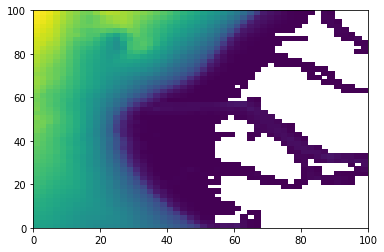

In [6]:
plt.pcolormesh(Bathymetry[400*2:450*2, 275*2:325*2]);

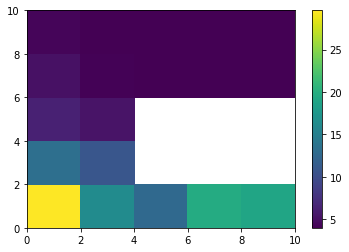

In [7]:
plt.pcolormesh(Bathymetry[800:810, 600:610])
plt.colorbar();

## Write the File ##

In [8]:
filename = 'bathymetry_double_202206.nc'

In [9]:
# Add some global attributes
ds_attrs = {
    'acknowledgements':
        'from 202108 bathymetry',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'Bathymetry file, doubled by copying from 202108 bathymetry'
    ),
    'source': (
        'tools/double_resolution/bathymetry.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
}

In [11]:
da = {}
interpl = {
    'nav_lat': nav_lat,
    'nav_lon': nav_lon,
    'Bathymetry': Bathymetry
}
for var in interpl.keys():
    if var == 'nav_lat' or var == 'nav_lon' or var == 'Bathymetry':
        dims = ('y', 'x')
        coords = {'y': np.arange(ysize), 'x': np.arange(xsize)}
    else:
        dims = ('time', 'y', 'x')
        coords = {'time': [0], 'y': np.arange(ysize), 'x': np.arange(xsize)}            
    da[var] = xr.DataArray(
        data=interpl[var],
        name=var,
        dims=dims,
        attrs=single[var].attrs,
        coords=coords,
    )

In [12]:
ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
)

In [17]:
encoding = {'nav_lat': {'zlib': True, '_FillValue': 0,},
            'nav_lon': {'zlib': True, '_FillValue': 0,},
           'Bathymetry': {'zlib': True, '_FillValue': 0, 'least_significant_digit': 0.1} }
ds.to_netcdf(
    path=filename,
    encoding=encoding,
)

In [18]:
double_coordinates.close()